# SEIRD Data Fitting Model from Henri Froesi for Brazilian States Covid19 - Evolution and Prediction

## References: 

### [1] Modelling Beyond the Basic SIR Model - Henri Froesi - Towards Data Science
#### https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4

### [2] Infectious Disease Modelling. Fitting Your Model to Corona Virus Data - Henri Froesi-Towards Data Science
#### https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

### Adapted by Ivan Carlos P. da Cruz (GitHub @icpcruz)
### Revision and contributions by Eduardo Correa Araújo

# Model summary ref. [1]

<img src="SEIRD%20model%20-%20general.png" style="width:600px" />

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 

from scipy.integrate import odeint

# !pip install lmfit - DONE !
import lmfit
from lmfit import Model # classe lmfit para a criação do modelo de fitting

import numdifftools # permite que lmfit calcule a matriz de correlações

import datetime

import warnings
warnings.filterwarnings('ignore')

#### para centralizar os gráficos na página 

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Importação de dados de óbitos diários por estado brasileiro (NE)

### Diretório sincronizado com o GitHub dos dados (arquivos csv):

In [3]:
path = "C:/Users/Ivan/Documents/GitHub/googleData/data/"

### Dicionário de nomes dos arquivos de óbitos diários por estado do NE

In [4]:
pref = "ON"
suf  = "_An.csv"
Data_files_names = {
    "Alagoas"    : pref+"AiL"+suf ,
    "Bahia"      : pref+"BiA"+suf ,
    "Ceará"      : pref+"CiE"+suf ,
    "Maranhão"   : pref+"MiA"+suf ,
    "Paraíba"    : pref+"PiB"+suf ,
    "Pernambuco" : pref+"PiE"+suf ,
    "Piauí"      : pref+"PiI"+suf ,
    "RioGrdoN"   : pref+"RiN"+suf ,
    "Sergipe"    : pref+"SiE"+suf
}

### Leitura dos arquivos (atualizados diariamente)

In [5]:
data_ON_AL = pd.read_csv(path+Data_files_names["Alagoas"], sep =",")
data_ON_BA = pd.read_csv(path+Data_files_names["Bahia"], sep =",")
data_ON_CE = pd.read_csv(path+Data_files_names["Ceará"], sep =",")
data_ON_MA = pd.read_csv(path+Data_files_names["Maranhão"], sep =",")
data_ON_PB = pd.read_csv(path+Data_files_names["Paraíba"], sep =",")
data_ON_PE = pd.read_csv(path+Data_files_names["Pernambuco"], sep =",")
data_ON_PI = pd.read_csv(path+Data_files_names["Piauí"], sep =",")
data_ON_RN = pd.read_csv(path+Data_files_names["RioGrdoN"], sep =",")
data_ON_SE = pd.read_csv(path+Data_files_names["Sergipe"], sep =",")

### "Parsing" das datas

In [6]:
format_str = "%Y-%m-%d"
data_ON_AL['Data'] = data_ON_AL['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_BA['Data'] = data_ON_BA['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_CE['Data'] = data_ON_CE['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_MA['Data'] = data_ON_MA['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_PB['Data'] = data_ON_PB['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_PE['Data'] = data_ON_PE['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_PI['Data'] = data_ON_PI['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_RN['Data'] = data_ON_RN['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_SE['Data'] = data_ON_SE['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))

In [7]:
data_ON_CE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
Data        85 non-null datetime64[ns]
ONCiE_An    85 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


In [8]:
data_ON_CE.tail()

,Data,ONCiE_An
80,2020-06-05,77.0
81,2020-06-06,75.0
82,2020-06-07,17.0
83,2020-06-08,138.0
84,2020-06-09,189.0


In [9]:
data_ON_CE.describe()

,ONCiE_An
count,85.000000
mean,50.694118
std,60.005560
min,0.000000
25%,4.000000
50%,25.000000
75%,75.000000
max,261.000000


### Definindo as colunas 'Data' como índices

In [10]:
data_ON_AL.set_index('Data')
data_ON_BA.set_index('Data')
data_ON_CE.set_index('Data')
data_ON_MA.set_index('Data')
data_ON_PB.set_index('Data')
data_ON_PE.set_index('Data')
data_ON_PI.set_index('Data')
data_ON_RN.set_index('Data')
data_ON_SE.set_index('Data')
data_ON_CE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
Data        85 non-null datetime64[ns]
ONCiE_An    85 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


## Parâmetros Epidemiológicos Assumidos para a Covid-19 (como universais) p/o SEIRD

In [11]:
#
# VALORES MÉDIOS ASSUMIDOS (ref. https://theconversation.com/how-long-are-you-infectious-when-you-have-coronavirus-135295):
#
num_of_incubation     = 5      # número de dias de incubação da doença (1/delta). 
num_of_infecting_days = 9      # número de dias que um infectado (ativo) infecta outros (= D = 1/gama)
num_to_dead           = 17     # número de dias para evoluir de infectado para óbito (1/rho)
subnotif_index        = 12     # número de vezes que os casos reais de infectados é maior que os notificados
apparent_letality     = 0.065  # taxa aparente de letalidade (% dos notificados que vão a óbito)
#
Epi_days              = 200    # duração arbitrada da pandemia
#
# FREQUÊNCIAS (POR DIA) CORRESPONDENTES
#
alpha = apparent_letality/subnotif_index
delta = 1/num_of_incubation
gamma = 1/num_of_infecting_days  
rho   = 1/num_to_dead
#
print('\n','*** PARÂMETROS EPIDEMIOLÓGICOS ADOTADOS NO MODELO SEIRD:','\n')
print('    Freq de letalidade   (alpha) = {:.3f}'.format(alpha))
print('    Freq de incubação    (delta) = {:.3f}'.format(delta))
print('    Freq de infetividade (gamma) = {:.3f}'.format(gamma))
print('    Freq para óbito      (rho)   = {:.3f}'.format(rho))


 *** PARÂMETROS EPIDEMIOLÓGICOS ADOTADOS NO MODELO SEIRD: 

    Freq de letalidade   (alpha) = 0.005
    Freq de incubação    (delta) = 0.200
    Freq de infetividade (gamma) = 0.111
    Freq para óbito      (rho)   = 0.059


### Dados da população por estado

In [12]:
N_BR ={"Brasil": 210147125, 
             "Nordeste": 
                 {'MA':7075181, 
                  'PI':3273227, 
                  'CE':9132078, 
                  'RN':3506853, 
                  'PB':4018127, 
                  'PE':9557071, 
                  'AL':3337357, 
                  'SE':2298696, 
                  'BA':14873064}, 
             "Norte": 
                 {'RO':1777225, 
                  'AC':881935, 
                  'AM':4144597, 
                  'RR': 605761, 
                  'PA':8602865, 
                  'AP':845731, 
                  'TO':1572866}, 
             "Sudeste": 
                 {'MG':21168791,
                  'ES':4018650, 
                  'RJ':17264943, 
                  'SP':45919049}, 
             "Sul": 
                 {'PR':11433957, 
                  'SC':7164788, 
                  'RS':11377239}, 
             "Centro-Oeste": 
                 {'MS':2778986, 
                  'MT':3484466, 
                  'GO':7018354, 
                  'DF':3015268} }

# Modelo com R_0 (e "beta") dependentes do tempo

### Função sistema de EDOs do modelo SEIRD que é recursivamente chamada pelo solver das ODEs

In [13]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    #
    S, E, I, R, D = y
    #
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    #
    return dSdt, dEdt, dIdt, dRdt, dDdt

### R_0(t) como uma função degrau de 2 alturas (c/5 parâms a serem ajustados pelo algorítimo de fitting/otimização)

In [14]:
def dois_saltos_R_0(t, R_0_start, x0, R_0_mid, x1, R_0_end):
    if (R_0_start>R_0_mid>R_0_end) and (x0<x1):
        if t < x0:
            f = R_0_start
        elif x0 <=t < x1:
            f = R_0_mid
        else:
            f = R_0_end
    else:
        f = np.average(np.absolute(np.array([R_0_start, R_0_mid, R_0_end])))
    return f 

### Gráfico da função degrau para R_0_(t) (OBS: não há interpolação linear entre os patamares)

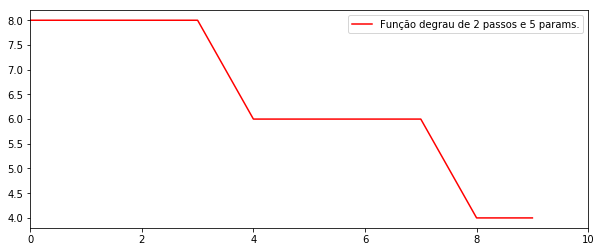

In [15]:
xt=np.arange(10)
yt=np.zeros(10)
i = 0
for item in xt:
    yt[i] = dois_saltos_R_0(xt[i], 8, 4, 6, 8, 4)
    i += 1

plt.figure(figsize = [10, 4])
plt.xlim(0,10)
plt.plot(xt, yt, label = 'Função degrau de 2 passos e 5 params.', color='r')
plt.legend()
plt.show()

#### Os parâmetros que serão ajustados no processo de otimização (fitting), são:

#### Valores inicias arbitrados dos parâmetros para o processo de otimização dados como tuplas (esperado, mínimo, máximo)

In [16]:
params_init_min_max = {"R_0_start": (3.5, 2.0, 6.0),
                       "x0":        (10.0, 2.0, 100.0),
                       "R_0_mid":   (1.5, 0.5 , 3),
                       "x1":        (110, 100.1, 250), 
                       "R_0_end":   (0.6, 0.1, 1.5)}

# Ajuste das curvas R_0(t) e SEIRD a partir dos dados de mortalidade diária

### Definição da função solver do sistema de EDOs do modelo SEIRD que é recursivamente chamada pelo algoritmo de otimização (fitting aos dados) 

In [17]:
def SolverEDOs(days, N, R_0_start, x0, R_0_mid, x1, R_0_end):
    #
    # definição da função beta(t) = R_0(t)*gama
    #
    def beta(t):
        return dois_saltos_R_0(t, R_0_start, x0, R_0_mid, x1, R_0_end) * gamma
    #
    # Valores iniciais das variáveid do SEIRD: N-1 (população), 1 exposto, 0 infectado, recuperados ou mortos
    #
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0
    #
    # geração da grid temporal a partir da quantidade de dias informados
    #
    t = np.arange(days)
    #print(t)
    #
    # Integração do sistema de EDOs - o sistema é passado pela função 'deriv' na chamada do solver
    #
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    #
    # Salvando os resultados nas variáveis do sistema
    #
    S, E, I, R, D = ret.T
    #
    # Cálculo de R_0(t)
    #
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    #
    return t, S, E, I, R, D, R_0_over_time

### Estado teste: Maranhão

In [18]:
N = N_BR['Nordeste']['MA']                 # <-- população do estado
y_data = data_ON_MA['ONMiA_An'].to_numpy() # <-- de pandas series para numpy array - ndarray 
x_data = np.arange(len(y_data))            # <-- do dia 1 ao final da série (Python inicia em 'zero', daí o +1)
days   = len(x_data)                       # <-- duração, até "hoje", da pandemia no estado, para o fitting dos parâmetros

### Definição da função de fitting que chama o solver das EDOs

In [19]:
def fitter(x, R_0_start, x0, R_0_mid, x1, R_0_end):
    ret = SolverEDOs(days, N, R_0_start, x0, R_0_mid, x1, R_0_end) # <-- chama solver das EDOs (q chama odeint para integrar)
    deaths_fitted = ret[5]                                            # <-- óbitos: 6o elem. da tupla (t, S, E, I, R, D, R_0)
    return deaths_fitted[x]                                           # <-- retorna vetor com as fatalidades no tempo 

### Criando o modelo de fitting com o pacote 'lmfit' 

In [20]:
# Cria o modelo de fitting passando a função fitter como parâmetro para lmfit 
#
mod = lmfit.Model(fitter)
#
# Criação do vetor de parâmetros para o fitting, incluindo 3 estimativas iniciais (inicial, min, max) p/cada parâmetro
#
for kwarg, (init, mini, maxi) in params_init_min_max.items(): # <-- usa as estimativas fornecidas acima
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
#
# Criação do vetor de parâmetros para o otimizador
#
params = mod.make_params()

In [21]:
params

name,value,initial value,min,max,vary
R_0_start,3.50000000,None,2.00000000,6.00000000,True
x0,10.0000000,None,2.00000000,100.000000,True
R_0_mid,1.50000000,None,0.50000000,3.00000000,True
x1,110.000000,None,100.100000,250.000000,True
R_0_end,0.60000000,None,0.10000000,1.50000000,True


### Realizando o fitting com os dados de óbitos diários (não suavizados)

In [22]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

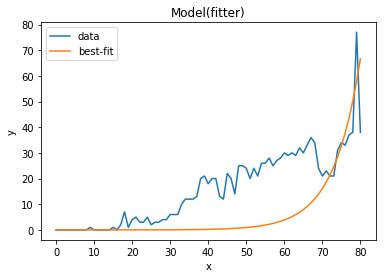

In [23]:
result.plot_fit(datafmt="-");

In [24]:
result

## Realizando o fitting com os dados de óbitos diários suavizados (por média móvel)

In [25]:
window_size = 10 #  <-- tamanho da janela móvel para a suavização

# First, we need to convert y_data Numpy ndarray to a Pandas Series

y_series = pd.Series(y_data)

# Tail-rolling average transform

y_rolling_S = y_series.rolling(window=window_size).mean().dropna()

# Now getting back to a ndarray

y_rolling = y_rolling_S.to_numpy()
x_rolling = x_data[window_size-1:] # <-- remove os 'n-1' pontos do início da série por conta da média móvel sobre 'n' pontos


In [26]:
result_roll = mod.fit(y_rolling, params, method="least_squares", x=x_rolling)

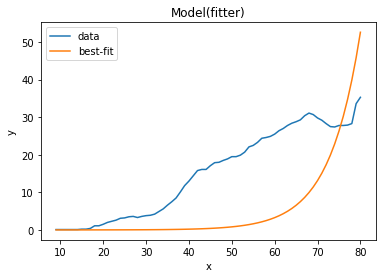

In [27]:
result_roll.plot_fit(datafmt="-");

In [34]:
result_roll

### Parâmetros otimizados do modelo com dados diários (suavizados)

#### Vetor de parâmetros para usar na geração dos gráficos e data_frame dos forecasts

In [37]:
paramsfit = result_roll.best_values
#
parametros = []
parametros.append(paramsfit['R_0_start'])
parametros.append(paramsfit['x0'])
parametros.append(paramsfit['R_0_mid'])
parametros.append(paramsfit['x1'])
parametros.append(paramsfit['R_0_end'])

#### Parâmetros da função R_0(t) (função degrau - 2 saltos) 

In [38]:
print('\n','*** PARÂMETROS OTIMIZADOS DA FUNC 2-DEGRAUS DE R_0 PELO FITTING COM OS DADOS DE ÓBITOS:','\n')
print('    R_0_start = {:.2f}'.format(paramsfit['R_0_start']))
print('    x_0       = {:.2f}'.format(paramsfit['x0']))
print('    R_0_mid   = {:.2f}'.format(paramsfit['R_0_mid']))
print('    x_1       = {:.2f}'.format(paramsfit['x1']))
print('    R_0_end   = {:.2f}'.format(paramsfit['R_0_end']))


 *** PARÂMETROS OTIMIZADOS DA FUNC 2-DEGRAUS DE R_0 PELO FITTING COM OS DADOS DE ÓBITOS: 

    R_0_start = 3.81
    x_0       = 95.21
    R_0_mid   = 1.53
    x_1       = 110.00
    R_0_end   = 0.60


### Chamada do SOLVER com os parâmetros otimizados da função degrau para R_0(t) para obter as var SEIRD

In [35]:
#
# Definição do período da pandemia para efeito de traçar-se os gráficos de evolução r poder fazer forecast
#
Epi_days = 250 # <-- tempo estimado de duração da pandemia

In [39]:
res_SEIRD_roll = SolverEDOs(Epi_days, N,*parametros)

## Relatórios de acurácia e intervalo de confiança do fitting dos dados suavizados

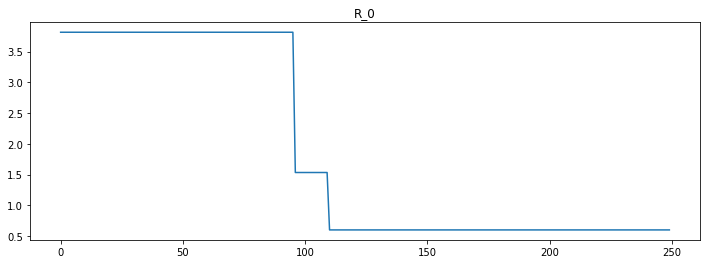

In [43]:
plt.figure(figsize = [12, 4])
#plt.xlim(30,60)
plt.title('R_0')
plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[6], label = 'R_0')

### Intervalos de confiança (processamento leva +6 mins.)

In [ ]:
#start_time = time.time()
#
#Conf_Interval = result_roll.ci_report()
#elapsed_time = time.time() - start_time
#elapsed_time

In [ ]:
#Conf_Interval

### Plotagem dos resíduos

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

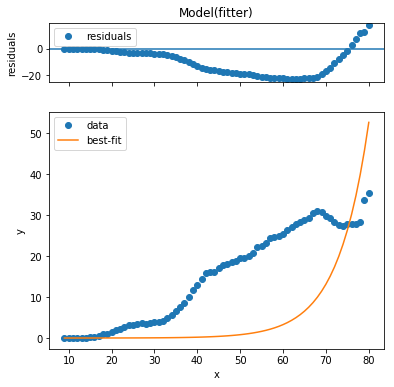

In [44]:
result_roll.plot() # _residuals

### Avaliação das incertezas - 50% e 90% de intervalos de confiança

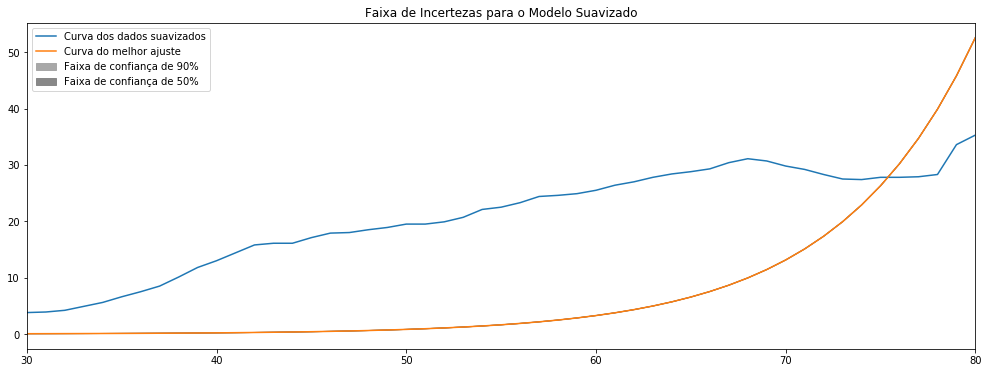

In [45]:
result_roll_50 = result_roll.eval_uncertainty(x=x_rolling, sigma = 0.50)

result_roll_90 = result_roll.eval_uncertainty(x=x_rolling, sigma = 0.90)

plt.figure(figsize = [17, 6])
plt.xlim(30,80)
plt.title('Faixa de Incertezas para o Modelo Suavizado')
plt.plot(x_rolling, y_rolling, label='Curva dos dados suavizados')
plt.plot(x_rolling, result_roll.best_fit, label= 'Curva do melhor ajuste')
plt.fill_between(x_rolling, result_roll.best_fit-result_roll_90,
                 result_roll.best_fit+result_roll_90, color='#A8A8A8',label = 'Faixa de confiança de 90%')
plt.fill_between(x_rolling, result_roll.best_fit-result_roll_50,
                 result_roll.best_fit+result_roll_50, color='#888888', label = 'Faixa de confiança de 50%')
plt.legend(loc=2)
plt.show()

In [47]:
res_SEIRD_roll = SolverEDOs(Epi_days, N,*parametros)

# Plotagem das curvas SEIRD para o modelo com dados suavizados

### Curvas IED (S e R fora de escala nessa fase da pandemia)

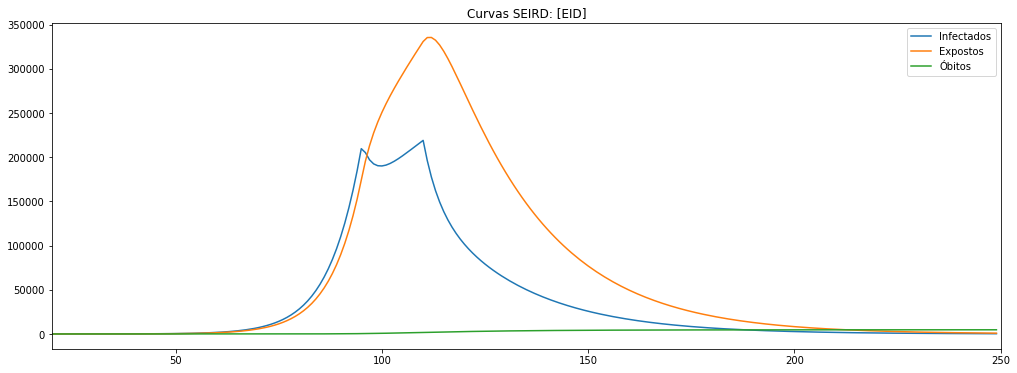

In [49]:
plt.figure(figsize = [17, 6])
plt.title('Curvas SEIRD: [EID]')
plt.xlim(20,250)
#plt.plot(res_SEIRD[0],res_SEIRD[1], label = 'Suscetíveis')
plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[2], label = 'Infectados')
plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[3], label = 'Expostos')
#plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[4], label = 'Recuperados')
plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[5], label = 'Óbitos')
plt.legend()
plt.show()

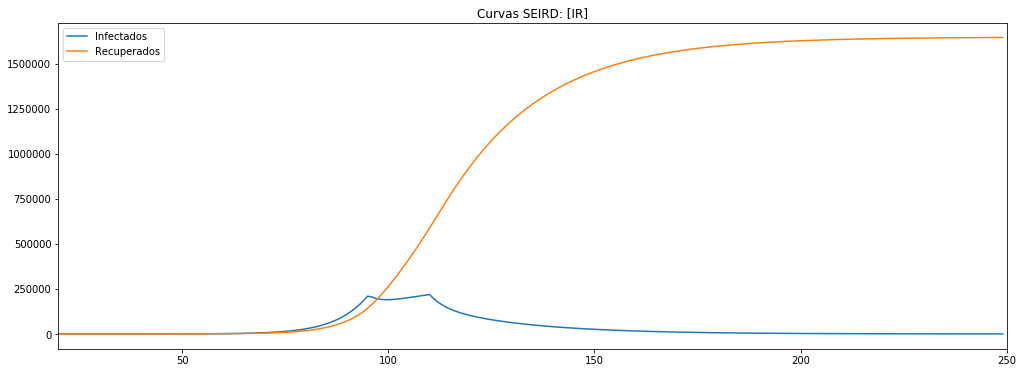

In [51]:
plt.figure(figsize = [17, 6])
plt.title('Curvas SEIRD: [IR]')
plt.xlim(20,250)
#plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[1], label = 'Suscetíveis')
plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[2], label = 'Infectados')
#plt.plot(dados[0],dados[3], label = 'Expostos')
plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[4], label = 'Recuperados')
plt.legend()
plt.show()

### Ajuste da curva estimada de óbitos aos dados suavizados (média móvel de 10 dias)

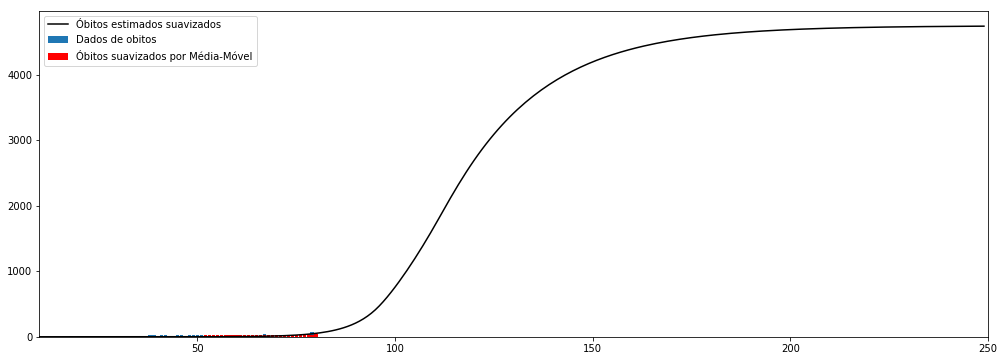

In [53]:
plt.figure(figsize = [17, 6])
plt.xlim(10,250)
#plt. ylim(0,40)
plt.bar(x_data, y_data,                       label = 'Dados de obitos')
plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[5], label = 'Óbitos estimados suavizados', color='black')
plt.bar(x_rolling, y_rolling,                 label = 'Óbitos suavizados por Média-Móvel', color='red')
plt.legend()
plt.show()

### Zoom no trecho com dados

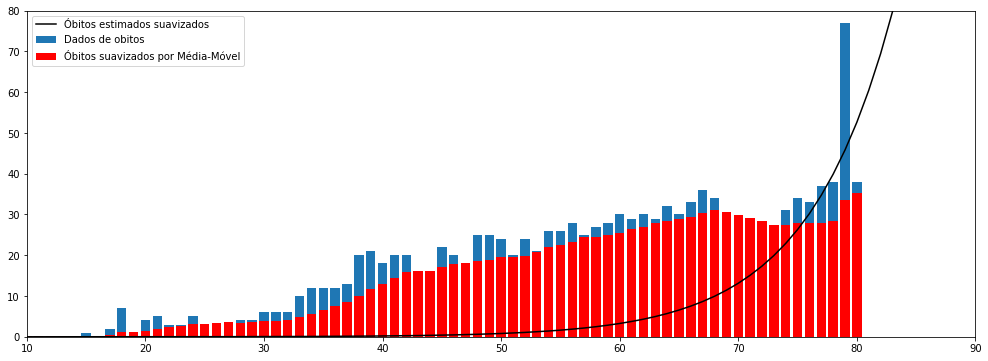

In [60]:
plt.figure(figsize = [17, 6])
plt.xlim(10,90)
plt. ylim(0,80)
plt.bar(x_data, y_data,                       label = 'Dados de obitos')
plt.plot(res_SEIRD_roll[0],res_SEIRD_roll[5], label = 'Óbitos estimados suavizados', color='black')
plt.bar(x_rolling, y_rolling,                 label = 'Óbitos suavizados por Média-Móvel', color='red')
plt.legend()
plt.show()

### Forecast para 14 dias (com os dados suavizados)

In [54]:
period = 14 #<-- days forecast
#
last_day_in_data = x_rolling[len(x_rolling) - 1]
last_day_forecast  = last_day_in_data + period

In [55]:
Day = pd.Series(res_SEIRD_roll[0])
S   = pd.Series(res_SEIRD_roll[1])
E   = pd.Series(res_SEIRD_roll[2])
I   = pd.Series(res_SEIRD_roll[3])
R   = pd.Series(res_SEIRD_roll[4])
D   = pd.Series(res_SEIRD_roll[5])

In [56]:
df = pd.DataFrame()
df['Dia da Epidemia'] = Day
df['Suscetíveis']     = S
df['Expostos']        = E
df['Infectados']      = I
df['Recuperados']     = R
df['Óbitos']          = D
#
df.set_index(['Dia da Epidemia'])
#
pd.options.display.float_format = '{:,.0f}'.format
df[last_day_in_data : last_day_forecast]

,Dia da Epidemia,Suscetíveis,Expostos,Infectados,Recuperados,Óbitos
80,80,"7,005,561","28,447","22,872","18,249",53
81,81,"6,995,280","32,629","26,252","20,959",60
82,82,"6,983,501","37,415","30,126","24,069",69
83,83,"6,970,008","42,890","34,565","27,638",80
84,84,"6,954,561","49,147","39,649","31,733",91
85,85,"6,936,887","56,293","45,468","36,428",105
86,86,"6,916,678","64,446","52,124","41,813",121
87,87,"6,893,586","73,739","59,733","47,984",138
88,88,"6,867,224","84,318","68,425","55,055",159
89,89,"6,837,157","96,344","78,345","63,152",182


In [57]:
df.describe()

,Dia da Epidemia,Suscetíveis,Expostos,Infectados,Recuperados,Óbitos
count,250,250,250,250,250,250
mean,124,"6,136,225","33,018","59,534","843,971","2,433"
std,72,"738,215","57,919","94,600","733,140","2,114"
min,0,"5,424,507",1,0,0,0
25%,62,"5,440,616",501,"1,086","1,554",4
50%,124,"5,702,170","4,103","8,881","1,059,252","3,054"
75%,187,"7,069,224","33,372","72,858","1,609,932","4,642"
max,249,"7,075,180","219,069","335,539","1,644,708","4,742"
